# Predict Future Sale - Baseline
## Final project for "How to win a data science competition" Coursera course
https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data  
>Student: Rafael Caneiro de Oliveira  
>Email: rafael.caneiro@gmail.com  
>Date: 04/08/2020

## Load

In [1]:
import numpy as np
import pandas as pd
from itertools import product

from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

PATH = Path.cwd().parent
DATA_PATH = Path(PATH, "./data/raw/") 
MODEL_PATH = Path(PATH, "./models/") 

seed = 42

In [2]:
sales = pd.read_csv(Path(DATA_PATH,"sales_train.csv"))
items = pd.read_csv(Path(DATA_PATH,"items.csv"))
categories = pd.read_csv(Path(DATA_PATH,"item_categories.csv"))
shops = pd.read_csv(Path(DATA_PATH,"shops.csv"))
test = pd.read_csv(Path(DATA_PATH,"test.csv"))
test["date_block_num"]=34

## Aggregate

In [3]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'})

#fix column names
gb.rename({"item_cnt_day":"target"}, inplace=True, axis=1)

#join aggregated data to the grid
train = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

#sort the data
train.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

## Join

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [5]:
train = train.merge(items, on="item_id", how="left")
train = train.merge(categories, on="item_category_id", how="left")
train = train.merge(shops, on="shop_id", how="left")
train.drop(columns=["item_name", "shop_name", "item_category_name"], inplace=True)
train = reduce_mem_usage(train)
train.head() 

Memory usage after optimization is: 156.12 MB
Decreased by 58.3%


,shop_id,item_id,date_block_num,target,item_category_id
0,0,19,0,0.0,40
1,0,27,0,0.0,19
2,0,28,0,0.0,30
3,0,29,0,0.0,23
4,0,32,0,6.0,40


In [6]:
test = test.merge(items, on="item_id", how="left")
test = test.merge(categories, on="item_category_id", how="left")
test = test.merge(shops, on="shop_id", how="left")
test.drop(columns=["item_name", "shop_name", "item_category_name"], inplace=True)
test = reduce_mem_usage(test)
test.head()

Memory usage after optimization is: 3.47 MB
Decreased by 64.6%


,ID,shop_id,item_id,date_block_num,item_category_id
0,0,5,5037,34,19
1,1,5,5320,34,55
2,2,5,5233,34,19
3,3,5,5232,34,23
4,4,5,5268,34,20


## Test / Validation Split

In [7]:
def get_index(start, end, df, col):
    ls = [x for x in range(start , end + 1)]
    idx = df[df[col].isin(ls)].index.ravel()
    return idx

# 2013-jan >> 2013-oct
train_1 = get_index(0, 10, train, "date_block_num")

# 2013-nov
val_1 = get_index(10, 10, train, "date_block_num")

# 2014-jan >> 2014-oct
train_2 = get_index(12, 22, train, "date_block_num")

# 2014-nov
val_2 = get_index(22, 22, train, "date_block_num")

# 2015-jan >> 2015-sep
train_3 = get_index(24, 33, train, "date_block_num")

# 2015-oct
val_3 = get_index(33, 33, train, "date_block_num")

# 2013-jan >> 2015-sep
train_val = get_index(0, 33, train, "date_block_num")

# 2013-jan >> 2015-out
train_all = get_index(0, 34, train, "date_block_num")

folds = [(train_1, val_1), (train_2, val_2), (train_3, val_3)]

## Features / Target

In [8]:
remove_cols = ["target", "item_name", "item_category_name", "shop_name"]
features = [col for col in train.columns if col not in remove_cols]
target="target"
print(features)
print(target)

['shop_id', 'item_id', 'date_block_num', 'item_category_id']
target


## Model

In [15]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

parameters = {"tree_method":"gpu_hist",
              "n_jobs":-1,
              "seed":seed}

reg = XGBRegressor(**parameters)

param_list = {"learning_rate":[0.03, 0.01, 0.3, 0.1, 1],
              "n_estimators":[100, 300, 500],
              "max_depth":range(2, 21, 1),
              "min_child_weight":range(2, 33, 3),
              "gamma":[0.001, 0.003, 0.03, 0.01, 0.3, 0.1, 1, 3, 10, 30],
              "subsample":[0.1, 0.3, 0.5, 0.7, 0.8, 0.9],
              "colsample_bytree":[0.1, 0.3, 0.5, 0.7, 0.8, 0.9]}

rand_search = RandomizedSearchCV(estimator=reg,
                                 param_distributions=param_list,
                                 n_iter=500,
                                 scoring="neg_root_mean_squared_error",
                                 pre_dispatch=1,
                                 n_jobs=1,
                                 cv=folds,
                                 verbose=2,
                                 random_state=seed)

search_model = rand_search.fit(train[features], train[target])

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV] subsample=0.5, n_estimators=300, min_child_weight=32, max_depth=9, learning_rate=0.3, gamma=1, colsample_bytree=0.1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.5, n_estimators=300, min_child_weight=32, max_depth=9, learning_rate=0.3, gamma=1, colsample_bytree=0.1, total=  14.1s
[CV] subsample=0.5, n_estimators=300, min_child_weight=32, max_depth=9, learning_rate=0.3, gamma=1, colsample_bytree=0.1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s remaining:    0.0s


[CV]  subsample=0.5, n_estimators=300, min_child_weight=32, max_depth=9, learning_rate=0.3, gamma=1, colsample_bytree=0.1, total=  12.3s
[CV] subsample=0.5, n_estimators=300, min_child_weight=32, max_depth=9, learning_rate=0.3, gamma=1, colsample_bytree=0.1 
[CV]  subsample=0.5, n_estimators=300, min_child_weight=32, max_depth=9, learning_rate=0.3, gamma=1, colsample_bytree=0.1, total=   9.1s
[CV] subsample=0.3, n_estimators=300, min_child_weight=23, max_depth=9, learning_rate=0.1, gamma=0.1, colsample_bytree=0.7 
[CV]  subsample=0.3, n_estimators=300, min_child_weight=23, max_depth=9, learning_rate=0.1, gamma=0.1, colsample_bytree=0.7, total=  16.3s
[CV] subsample=0.3, n_estimators=300, min_child_weight=23, max_depth=9, learning_rate=0.1, gamma=0.1, colsample_bytree=0.7 
[CV]  subsample=0.3, n_estimators=300, min_child_weight=23, max_depth=9, learning_rate=0.1, gamma=0.1, colsample_bytree=0.7, total=  14.4s
[CV] subsample=0.3, n_estimators=300, min_child_weight=23, max_depth=9, learni

[CV]  subsample=0.3, n_estimators=500, min_child_weight=29, max_depth=19, learning_rate=0.1, gamma=0.3, colsample_bytree=0.3, total=  25.0s
[CV] subsample=0.3, n_estimators=500, min_child_weight=29, max_depth=19, learning_rate=0.1, gamma=0.3, colsample_bytree=0.3 
[CV]  subsample=0.3, n_estimators=500, min_child_weight=29, max_depth=19, learning_rate=0.1, gamma=0.3, colsample_bytree=0.3, total=  22.7s
[CV] subsample=0.3, n_estimators=500, min_child_weight=29, max_depth=19, learning_rate=0.1, gamma=0.3, colsample_bytree=0.3 
[CV]  subsample=0.3, n_estimators=500, min_child_weight=29, max_depth=19, learning_rate=0.1, gamma=0.3, colsample_bytree=0.3, total=  17.3s
[CV] subsample=0.5, n_estimators=500, min_child_weight=17, max_depth=19, learning_rate=0.03, gamma=0.03, colsample_bytree=0.1 
[CV]  subsample=0.5, n_estimators=500, min_child_weight=17, max_depth=19, learning_rate=0.03, gamma=0.03, colsample_bytree=0.1, total=  34.7s
[CV] subsample=0.5, n_estimators=500, min_child_weight=17, ma

[CV]  subsample=0.8, n_estimators=500, min_child_weight=23, max_depth=6, learning_rate=1, gamma=0.1, colsample_bytree=0.5, total=  15.6s
[CV] subsample=0.1, n_estimators=500, min_child_weight=17, max_depth=16, learning_rate=0.1, gamma=10, colsample_bytree=0.8 
[CV]  subsample=0.1, n_estimators=500, min_child_weight=17, max_depth=16, learning_rate=0.1, gamma=10, colsample_bytree=0.8, total=  20.5s
[CV] subsample=0.1, n_estimators=500, min_child_weight=17, max_depth=16, learning_rate=0.1, gamma=10, colsample_bytree=0.8 
[CV]  subsample=0.1, n_estimators=500, min_child_weight=17, max_depth=16, learning_rate=0.1, gamma=10, colsample_bytree=0.8, total=  16.7s
[CV] subsample=0.1, n_estimators=500, min_child_weight=17, max_depth=16, learning_rate=0.1, gamma=10, colsample_bytree=0.8 
[CV]  subsample=0.1, n_estimators=500, min_child_weight=17, max_depth=16, learning_rate=0.1, gamma=10, colsample_bytree=0.8, total=  12.3s
[CV] subsample=0.8, n_estimators=100, min_child_weight=20, max_depth=14, l

[CV]  subsample=0.9, n_estimators=500, min_child_weight=8, max_depth=16, learning_rate=0.3, gamma=30, colsample_bytree=0.5, total=  12.3s
[CV] subsample=0.9, n_estimators=500, min_child_weight=8, max_depth=16, learning_rate=0.3, gamma=30, colsample_bytree=0.5 
[CV]  subsample=0.9, n_estimators=500, min_child_weight=8, max_depth=16, learning_rate=0.3, gamma=30, colsample_bytree=0.5, total=   9.5s
[CV] subsample=0.8, n_estimators=300, min_child_weight=17, max_depth=15, learning_rate=0.3, gamma=0.3, colsample_bytree=0.3 
[CV]  subsample=0.8, n_estimators=300, min_child_weight=17, max_depth=15, learning_rate=0.3, gamma=0.3, colsample_bytree=0.3, total=  19.7s
[CV] subsample=0.8, n_estimators=300, min_child_weight=17, max_depth=15, learning_rate=0.3, gamma=0.3, colsample_bytree=0.3 
[CV]  subsample=0.8, n_estimators=300, min_child_weight=17, max_depth=15, learning_rate=0.3, gamma=0.3, colsample_bytree=0.3, total=  17.7s
[CV] subsample=0.8, n_estimators=300, min_child_weight=17, max_depth=15

[CV]  subsample=0.7, n_estimators=300, min_child_weight=14, max_depth=9, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7, total=  22.1s
[CV] subsample=0.7, n_estimators=300, min_child_weight=14, max_depth=9, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7 
[CV]  subsample=0.7, n_estimators=300, min_child_weight=14, max_depth=9, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7, total=  19.4s
[CV] subsample=0.7, n_estimators=300, min_child_weight=14, max_depth=9, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7 
[CV]  subsample=0.7, n_estimators=300, min_child_weight=14, max_depth=9, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7, total=  14.5s
[CV] subsample=0.1, n_estimators=100, min_child_weight=29, max_depth=20, learning_rate=0.03, gamma=10, colsample_bytree=0.8 
[CV]  subsample=0.1, n_estimators=100, min_child_weight=29, max_depth=20, learning_rate=0.03, gamma=10, colsample_bytree=0.8, total=   8.8s
[CV] subsample=0.1, n_estimators=100, min_child_weight=29, max_depth=2

[CV]  subsample=0.9, n_estimators=300, min_child_weight=5, max_depth=6, learning_rate=1, gamma=0.03, colsample_bytree=0.8, total=   9.5s
[CV] subsample=0.3, n_estimators=100, min_child_weight=29, max_depth=8, learning_rate=0.03, gamma=0.003, colsample_bytree=0.3 
[CV]  subsample=0.3, n_estimators=100, min_child_weight=29, max_depth=8, learning_rate=0.03, gamma=0.003, colsample_bytree=0.3, total=   5.6s
[CV] subsample=0.3, n_estimators=100, min_child_weight=29, max_depth=8, learning_rate=0.03, gamma=0.003, colsample_bytree=0.3 
[CV]  subsample=0.3, n_estimators=100, min_child_weight=29, max_depth=8, learning_rate=0.03, gamma=0.003, colsample_bytree=0.3, total=   4.9s
[CV] subsample=0.3, n_estimators=100, min_child_weight=29, max_depth=8, learning_rate=0.03, gamma=0.003, colsample_bytree=0.3 
[CV]  subsample=0.3, n_estimators=100, min_child_weight=29, max_depth=8, learning_rate=0.03, gamma=0.003, colsample_bytree=0.3, total=   3.5s
[CV] subsample=0.1, n_estimators=100, min_child_weight=3

[CV]  subsample=0.8, n_estimators=300, min_child_weight=23, max_depth=18, learning_rate=0.3, gamma=0.003, colsample_bytree=0.8, total= 3.8min
[CV] subsample=0.8, n_estimators=300, min_child_weight=23, max_depth=18, learning_rate=0.3, gamma=0.003, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=300, min_child_weight=23, max_depth=18, learning_rate=0.3, gamma=0.003, colsample_bytree=0.8, total= 3.3min
[CV] subsample=0.8, n_estimators=300, min_child_weight=23, max_depth=18, learning_rate=0.3, gamma=0.003, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=300, min_child_weight=23, max_depth=18, learning_rate=0.3, gamma=0.003, colsample_bytree=0.8, total= 2.6min
[CV] subsample=0.3, n_estimators=500, min_child_weight=11, max_depth=16, learning_rate=0.3, gamma=0.01, colsample_bytree=0.9 
[CV]  subsample=0.3, n_estimators=500, min_child_weight=11, max_depth=16, learning_rate=0.3, gamma=0.01, colsample_bytree=0.9, total= 3.0min
[CV] subsample=0.3, n_estimators=500, min_child_weigh

[CV]  subsample=0.1, n_estimators=300, min_child_weight=2, max_depth=8, learning_rate=0.3, gamma=3, colsample_bytree=0.5, total=   7.0s
[CV] subsample=0.1, n_estimators=100, min_child_weight=5, max_depth=5, learning_rate=0.03, gamma=0.03, colsample_bytree=0.9 
[CV]  subsample=0.1, n_estimators=100, min_child_weight=5, max_depth=5, learning_rate=0.03, gamma=0.03, colsample_bytree=0.9, total=   3.3s
[CV] subsample=0.1, n_estimators=100, min_child_weight=5, max_depth=5, learning_rate=0.03, gamma=0.03, colsample_bytree=0.9 
[CV]  subsample=0.1, n_estimators=100, min_child_weight=5, max_depth=5, learning_rate=0.03, gamma=0.03, colsample_bytree=0.9, total=   3.2s
[CV] subsample=0.1, n_estimators=100, min_child_weight=5, max_depth=5, learning_rate=0.03, gamma=0.03, colsample_bytree=0.9 
[CV]  subsample=0.1, n_estimators=100, min_child_weight=5, max_depth=5, learning_rate=0.03, gamma=0.03, colsample_bytree=0.9, total=   2.2s
[CV] subsample=0.1, n_estimators=300, min_child_weight=14, max_depth=

[CV]  subsample=0.1, n_estimators=500, min_child_weight=32, max_depth=8, learning_rate=0.1, gamma=0.001, colsample_bytree=0.1, total=  15.0s
[CV] subsample=0.1, n_estimators=500, min_child_weight=32, max_depth=8, learning_rate=0.1, gamma=0.001, colsample_bytree=0.1 
[CV]  subsample=0.1, n_estimators=500, min_child_weight=32, max_depth=8, learning_rate=0.1, gamma=0.001, colsample_bytree=0.1, total=  13.4s
[CV] subsample=0.1, n_estimators=500, min_child_weight=32, max_depth=8, learning_rate=0.1, gamma=0.001, colsample_bytree=0.1 
[CV]  subsample=0.1, n_estimators=500, min_child_weight=32, max_depth=8, learning_rate=0.1, gamma=0.001, colsample_bytree=0.1, total=   9.7s
[CV] subsample=0.9, n_estimators=300, min_child_weight=32, max_depth=16, learning_rate=0.03, gamma=3, colsample_bytree=0.1 
[CV]  subsample=0.9, n_estimators=300, min_child_weight=32, max_depth=16, learning_rate=0.03, gamma=3, colsample_bytree=0.1, total=  26.4s
[CV] subsample=0.9, n_estimators=300, min_child_weight=32, max

[CV]  subsample=0.1, n_estimators=300, min_child_weight=20, max_depth=4, learning_rate=0.03, gamma=1, colsample_bytree=0.5, total=   4.2s
[CV] subsample=0.8, n_estimators=100, min_child_weight=32, max_depth=11, learning_rate=0.01, gamma=0.003, colsample_bytree=0.1 
[CV]  subsample=0.8, n_estimators=100, min_child_weight=32, max_depth=11, learning_rate=0.01, gamma=0.003, colsample_bytree=0.1, total=   9.3s
[CV] subsample=0.8, n_estimators=100, min_child_weight=32, max_depth=11, learning_rate=0.01, gamma=0.003, colsample_bytree=0.1 
[CV]  subsample=0.8, n_estimators=100, min_child_weight=32, max_depth=11, learning_rate=0.01, gamma=0.003, colsample_bytree=0.1, total=   8.3s
[CV] subsample=0.8, n_estimators=100, min_child_weight=32, max_depth=11, learning_rate=0.01, gamma=0.003, colsample_bytree=0.1 
[CV]  subsample=0.8, n_estimators=100, min_child_weight=32, max_depth=11, learning_rate=0.01, gamma=0.003, colsample_bytree=0.1, total=   5.9s
[CV] subsample=0.1, n_estimators=300, min_child_w

[CV]  subsample=0.1, n_estimators=500, min_child_weight=14, max_depth=12, learning_rate=0.1, gamma=0.03, colsample_bytree=0.7, total=  33.1s
[CV] subsample=0.1, n_estimators=500, min_child_weight=14, max_depth=12, learning_rate=0.1, gamma=0.03, colsample_bytree=0.7 
[CV]  subsample=0.1, n_estimators=500, min_child_weight=14, max_depth=12, learning_rate=0.1, gamma=0.03, colsample_bytree=0.7, total=  31.4s
[CV] subsample=0.1, n_estimators=500, min_child_weight=14, max_depth=12, learning_rate=0.1, gamma=0.03, colsample_bytree=0.7 
[CV]  subsample=0.1, n_estimators=500, min_child_weight=14, max_depth=12, learning_rate=0.1, gamma=0.03, colsample_bytree=0.7, total=  24.8s
[CV] subsample=0.8, n_estimators=500, min_child_weight=29, max_depth=19, learning_rate=0.1, gamma=10, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=500, min_child_weight=29, max_depth=19, learning_rate=0.1, gamma=10, colsample_bytree=0.8, total=  27.2s
[CV] subsample=0.8, n_estimators=500, min_child_weight=29, max

[CV]  subsample=0.1, n_estimators=100, min_child_weight=32, max_depth=16, learning_rate=0.1, gamma=0.003, colsample_bytree=0.9, total=  12.1s
[CV] subsample=0.8, n_estimators=300, min_child_weight=17, max_depth=12, learning_rate=0.03, gamma=0.003, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=300, min_child_weight=17, max_depth=12, learning_rate=0.03, gamma=0.003, colsample_bytree=0.8, total=  56.5s
[CV] subsample=0.8, n_estimators=300, min_child_weight=17, max_depth=12, learning_rate=0.03, gamma=0.003, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=300, min_child_weight=17, max_depth=12, learning_rate=0.03, gamma=0.003, colsample_bytree=0.8, total=  50.9s
[CV] subsample=0.8, n_estimators=300, min_child_weight=17, max_depth=12, learning_rate=0.03, gamma=0.003, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=300, min_child_weight=17, max_depth=12, learning_rate=0.03, gamma=0.003, colsample_bytree=0.8, total=  38.2s
[CV] subsample=0.8, n_estimators=100, min_chi

[CV]  subsample=0.7, n_estimators=100, min_child_weight=26, max_depth=2, learning_rate=1, gamma=0.001, colsample_bytree=0.8, total=   3.2s
[CV] subsample=0.7, n_estimators=100, min_child_weight=26, max_depth=2, learning_rate=1, gamma=0.001, colsample_bytree=0.8 
[CV]  subsample=0.7, n_estimators=100, min_child_weight=26, max_depth=2, learning_rate=1, gamma=0.001, colsample_bytree=0.8, total=   3.3s
[CV] subsample=0.7, n_estimators=100, min_child_weight=26, max_depth=2, learning_rate=1, gamma=0.001, colsample_bytree=0.8 
[CV]  subsample=0.7, n_estimators=100, min_child_weight=26, max_depth=2, learning_rate=1, gamma=0.001, colsample_bytree=0.8, total=   2.4s
[CV] subsample=0.7, n_estimators=100, min_child_weight=11, max_depth=6, learning_rate=0.1, gamma=0.001, colsample_bytree=0.3 
[CV]  subsample=0.7, n_estimators=100, min_child_weight=11, max_depth=6, learning_rate=0.1, gamma=0.001, colsample_bytree=0.3, total=   5.9s
[CV] subsample=0.7, n_estimators=100, min_child_weight=11, max_depth

[CV]  subsample=0.8, n_estimators=500, min_child_weight=14, max_depth=14, learning_rate=0.01, gamma=0.03, colsample_bytree=0.9, total= 2.9min
[CV] subsample=0.8, n_estimators=500, min_child_weight=14, max_depth=14, learning_rate=0.01, gamma=0.03, colsample_bytree=0.9 
[CV]  subsample=0.8, n_estimators=500, min_child_weight=14, max_depth=14, learning_rate=0.01, gamma=0.03, colsample_bytree=0.9, total= 2.2min
[CV] subsample=0.8, n_estimators=100, min_child_weight=8, max_depth=14, learning_rate=0.01, gamma=3, colsample_bytree=0.1 
[CV]  subsample=0.8, n_estimators=100, min_child_weight=8, max_depth=14, learning_rate=0.01, gamma=3, colsample_bytree=0.1, total=  10.1s
[CV] subsample=0.8, n_estimators=100, min_child_weight=8, max_depth=14, learning_rate=0.01, gamma=3, colsample_bytree=0.1 
[CV]  subsample=0.8, n_estimators=100, min_child_weight=8, max_depth=14, learning_rate=0.01, gamma=3, colsample_bytree=0.1, total=   8.5s
[CV] subsample=0.8, n_estimators=100, min_child_weight=8, max_depth

[CV]  subsample=0.8, n_estimators=100, min_child_weight=20, max_depth=3, learning_rate=1, gamma=10, colsample_bytree=0.1, total=   3.8s
[CV] subsample=0.8, n_estimators=100, min_child_weight=20, max_depth=3, learning_rate=1, gamma=10, colsample_bytree=0.1 
[CV]  subsample=0.8, n_estimators=100, min_child_weight=20, max_depth=3, learning_rate=1, gamma=10, colsample_bytree=0.1, total=   3.7s
[CV] subsample=0.8, n_estimators=100, min_child_weight=20, max_depth=3, learning_rate=1, gamma=10, colsample_bytree=0.1 
[CV]  subsample=0.8, n_estimators=100, min_child_weight=20, max_depth=3, learning_rate=1, gamma=10, colsample_bytree=0.1, total=   2.8s
[CV] subsample=0.3, n_estimators=500, min_child_weight=17, max_depth=6, learning_rate=0.01, gamma=0.01, colsample_bytree=0.1 
[CV]  subsample=0.3, n_estimators=500, min_child_weight=17, max_depth=6, learning_rate=0.01, gamma=0.01, colsample_bytree=0.1, total=  18.0s
[CV] subsample=0.3, n_estimators=500, min_child_weight=17, max_depth=6, learning_ra

[CV]  subsample=0.8, n_estimators=500, min_child_weight=5, max_depth=6, learning_rate=0.3, gamma=0.003, colsample_bytree=0.7, total=  20.5s
[CV] subsample=0.8, n_estimators=500, min_child_weight=5, max_depth=6, learning_rate=0.3, gamma=0.003, colsample_bytree=0.7 
[CV]  subsample=0.8, n_estimators=500, min_child_weight=5, max_depth=6, learning_rate=0.3, gamma=0.003, colsample_bytree=0.7, total=  15.4s
[CV] subsample=0.1, n_estimators=300, min_child_weight=11, max_depth=20, learning_rate=0.01, gamma=30, colsample_bytree=0.7 
[CV]  subsample=0.1, n_estimators=300, min_child_weight=11, max_depth=20, learning_rate=0.01, gamma=30, colsample_bytree=0.7, total=  13.4s
[CV] subsample=0.1, n_estimators=300, min_child_weight=11, max_depth=20, learning_rate=0.01, gamma=30, colsample_bytree=0.7 
[CV]  subsample=0.1, n_estimators=300, min_child_weight=11, max_depth=20, learning_rate=0.01, gamma=30, colsample_bytree=0.7, total=  12.3s
[CV] subsample=0.1, n_estimators=300, min_child_weight=11, max_de

[CV]  subsample=0.1, n_estimators=300, min_child_weight=26, max_depth=8, learning_rate=0.3, gamma=30, colsample_bytree=0.7, total=   5.5s
[CV] subsample=0.1, n_estimators=300, min_child_weight=26, max_depth=8, learning_rate=0.3, gamma=30, colsample_bytree=0.7 
[CV]  subsample=0.1, n_estimators=300, min_child_weight=26, max_depth=8, learning_rate=0.3, gamma=30, colsample_bytree=0.7, total=   5.5s
[CV] subsample=0.1, n_estimators=300, min_child_weight=26, max_depth=8, learning_rate=0.3, gamma=30, colsample_bytree=0.7 
[CV]  subsample=0.1, n_estimators=300, min_child_weight=26, max_depth=8, learning_rate=0.3, gamma=30, colsample_bytree=0.7, total=   4.5s
[CV] subsample=0.7, n_estimators=100, min_child_weight=26, max_depth=12, learning_rate=0.3, gamma=0.3, colsample_bytree=0.8 
[CV]  subsample=0.7, n_estimators=100, min_child_weight=26, max_depth=12, learning_rate=0.3, gamma=0.3, colsample_bytree=0.8, total=  15.1s
[CV] subsample=0.7, n_estimators=100, min_child_weight=26, max_depth=12, le

[CV]  subsample=0.9, n_estimators=100, min_child_weight=29, max_depth=8, learning_rate=0.01, gamma=0.03, colsample_bytree=0.9, total=   5.8s
[CV] subsample=0.5, n_estimators=500, min_child_weight=5, max_depth=13, learning_rate=0.1, gamma=30, colsample_bytree=0.5 
[CV]  subsample=0.5, n_estimators=500, min_child_weight=5, max_depth=13, learning_rate=0.1, gamma=30, colsample_bytree=0.5, total=  13.6s
[CV] subsample=0.5, n_estimators=500, min_child_weight=5, max_depth=13, learning_rate=0.1, gamma=30, colsample_bytree=0.5 
[CV]  subsample=0.5, n_estimators=500, min_child_weight=5, max_depth=13, learning_rate=0.1, gamma=30, colsample_bytree=0.5, total=  12.2s
[CV] subsample=0.5, n_estimators=500, min_child_weight=5, max_depth=13, learning_rate=0.1, gamma=30, colsample_bytree=0.5 
[CV]  subsample=0.5, n_estimators=500, min_child_weight=5, max_depth=13, learning_rate=0.1, gamma=30, colsample_bytree=0.5, total=  10.2s
[CV] subsample=0.5, n_estimators=300, min_child_weight=32, max_depth=6, lear

[CV]  subsample=0.9, n_estimators=100, min_child_weight=2, max_depth=4, learning_rate=0.3, gamma=0.003, colsample_bytree=0.3, total=   4.8s
[CV] subsample=0.9, n_estimators=100, min_child_weight=2, max_depth=4, learning_rate=0.3, gamma=0.003, colsample_bytree=0.3 
[CV]  subsample=0.9, n_estimators=100, min_child_weight=2, max_depth=4, learning_rate=0.3, gamma=0.003, colsample_bytree=0.3, total=   3.5s
[CV] subsample=0.8, n_estimators=300, min_child_weight=26, max_depth=17, learning_rate=0.01, gamma=0.003, colsample_bytree=0.5 
[CV]  subsample=0.8, n_estimators=300, min_child_weight=26, max_depth=17, learning_rate=0.01, gamma=0.003, colsample_bytree=0.5, total= 1.6min
[CV] subsample=0.8, n_estimators=300, min_child_weight=26, max_depth=17, learning_rate=0.01, gamma=0.003, colsample_bytree=0.5 
[CV]  subsample=0.8, n_estimators=300, min_child_weight=26, max_depth=17, learning_rate=0.01, gamma=0.003, colsample_bytree=0.5, total= 1.5min
[CV] subsample=0.8, n_estimators=300, min_child_weigh

[CV]  subsample=0.8, n_estimators=300, min_child_weight=2, max_depth=7, learning_rate=1, gamma=3, colsample_bytree=0.1, total=  11.8s
[CV] subsample=0.8, n_estimators=300, min_child_weight=2, max_depth=7, learning_rate=1, gamma=3, colsample_bytree=0.1 
[CV]  subsample=0.8, n_estimators=300, min_child_weight=2, max_depth=7, learning_rate=1, gamma=3, colsample_bytree=0.1, total=  10.8s
[CV] subsample=0.8, n_estimators=300, min_child_weight=2, max_depth=7, learning_rate=1, gamma=3, colsample_bytree=0.1 
[CV]  subsample=0.8, n_estimators=300, min_child_weight=2, max_depth=7, learning_rate=1, gamma=3, colsample_bytree=0.1, total=   8.4s
[CV] subsample=0.9, n_estimators=500, min_child_weight=29, max_depth=11, learning_rate=0.01, gamma=0.3, colsample_bytree=0.7 
[CV]  subsample=0.9, n_estimators=500, min_child_weight=29, max_depth=11, learning_rate=0.01, gamma=0.3, colsample_bytree=0.7, total= 1.2min
[CV] subsample=0.9, n_estimators=500, min_child_weight=29, max_depth=11, learning_rate=0.01, 

[CV]  subsample=0.8, n_estimators=300, min_child_weight=20, max_depth=13, learning_rate=1, gamma=0.03, colsample_bytree=0.8, total=  43.8s
[CV] subsample=0.8, n_estimators=100, min_child_weight=32, max_depth=7, learning_rate=0.01, gamma=1, colsample_bytree=0.1 
[CV]  subsample=0.8, n_estimators=100, min_child_weight=32, max_depth=7, learning_rate=0.01, gamma=1, colsample_bytree=0.1, total=   7.5s
[CV] subsample=0.8, n_estimators=100, min_child_weight=32, max_depth=7, learning_rate=0.01, gamma=1, colsample_bytree=0.1 
[CV]  subsample=0.8, n_estimators=100, min_child_weight=32, max_depth=7, learning_rate=0.01, gamma=1, colsample_bytree=0.1, total=   6.5s
[CV] subsample=0.8, n_estimators=100, min_child_weight=32, max_depth=7, learning_rate=0.01, gamma=1, colsample_bytree=0.1 
[CV]  subsample=0.8, n_estimators=100, min_child_weight=32, max_depth=7, learning_rate=0.01, gamma=1, colsample_bytree=0.1, total=   4.7s
[CV] subsample=0.1, n_estimators=100, min_child_weight=2, max_depth=6, learnin

[CV]  subsample=0.5, n_estimators=100, min_child_weight=32, max_depth=13, learning_rate=0.3, gamma=0.1, colsample_bytree=0.7, total=  12.1s
[CV] subsample=0.5, n_estimators=100, min_child_weight=32, max_depth=13, learning_rate=0.3, gamma=0.1, colsample_bytree=0.7 
[CV]  subsample=0.5, n_estimators=100, min_child_weight=32, max_depth=13, learning_rate=0.3, gamma=0.1, colsample_bytree=0.7, total=   9.6s
[CV] subsample=0.1, n_estimators=500, min_child_weight=17, max_depth=13, learning_rate=0.03, gamma=0.001, colsample_bytree=0.5 
[CV]  subsample=0.1, n_estimators=500, min_child_weight=17, max_depth=13, learning_rate=0.03, gamma=0.001, colsample_bytree=0.5, total=  41.0s
[CV] subsample=0.1, n_estimators=500, min_child_weight=17, max_depth=13, learning_rate=0.03, gamma=0.001, colsample_bytree=0.5 
[CV]  subsample=0.1, n_estimators=500, min_child_weight=17, max_depth=13, learning_rate=0.03, gamma=0.001, colsample_bytree=0.5, total=  39.3s
[CV] subsample=0.1, n_estimators=500, min_child_weigh

[CV]  subsample=0.7, n_estimators=500, min_child_weight=26, max_depth=3, learning_rate=0.3, gamma=0.03, colsample_bytree=0.9, total=  14.0s
[CV] subsample=0.7, n_estimators=500, min_child_weight=26, max_depth=3, learning_rate=0.3, gamma=0.03, colsample_bytree=0.9 
[CV]  subsample=0.7, n_estimators=500, min_child_weight=26, max_depth=3, learning_rate=0.3, gamma=0.03, colsample_bytree=0.9, total=  12.3s
[CV] subsample=0.7, n_estimators=500, min_child_weight=26, max_depth=3, learning_rate=0.3, gamma=0.03, colsample_bytree=0.9 
[CV]  subsample=0.7, n_estimators=500, min_child_weight=26, max_depth=3, learning_rate=0.3, gamma=0.03, colsample_bytree=0.9, total=   8.5s
[CV] subsample=0.9, n_estimators=300, min_child_weight=5, max_depth=15, learning_rate=0.01, gamma=3, colsample_bytree=0.7 
[CV]  subsample=0.9, n_estimators=300, min_child_weight=5, max_depth=15, learning_rate=0.01, gamma=3, colsample_bytree=0.7, total= 1.0min
[CV] subsample=0.9, n_estimators=300, min_child_weight=5, max_depth=1

[CV]  subsample=0.9, n_estimators=300, min_child_weight=26, max_depth=12, learning_rate=0.03, gamma=0.1, colsample_bytree=0.9, total=  37.7s
[CV] subsample=0.5, n_estimators=100, min_child_weight=20, max_depth=8, learning_rate=0.1, gamma=1, colsample_bytree=0.8 
[CV]  subsample=0.5, n_estimators=100, min_child_weight=20, max_depth=8, learning_rate=0.1, gamma=1, colsample_bytree=0.8, total=   6.3s
[CV] subsample=0.5, n_estimators=100, min_child_weight=20, max_depth=8, learning_rate=0.1, gamma=1, colsample_bytree=0.8 
[CV]  subsample=0.5, n_estimators=100, min_child_weight=20, max_depth=8, learning_rate=0.1, gamma=1, colsample_bytree=0.8, total=   5.9s
[CV] subsample=0.5, n_estimators=100, min_child_weight=20, max_depth=8, learning_rate=0.1, gamma=1, colsample_bytree=0.8 
[CV]  subsample=0.5, n_estimators=100, min_child_weight=20, max_depth=8, learning_rate=0.1, gamma=1, colsample_bytree=0.8, total=   4.3s
[CV] subsample=0.9, n_estimators=100, min_child_weight=17, max_depth=13, learning_

[CV]  subsample=0.7, n_estimators=300, min_child_weight=29, max_depth=13, learning_rate=0.01, gamma=0.01, colsample_bytree=0.5, total=  49.9s
[CV] subsample=0.7, n_estimators=300, min_child_weight=29, max_depth=13, learning_rate=0.01, gamma=0.01, colsample_bytree=0.5 
[CV]  subsample=0.7, n_estimators=300, min_child_weight=29, max_depth=13, learning_rate=0.01, gamma=0.01, colsample_bytree=0.5, total=  36.5s
[CV] subsample=0.8, n_estimators=100, min_child_weight=5, max_depth=20, learning_rate=1, gamma=0.3, colsample_bytree=0.3 
[CV]  subsample=0.8, n_estimators=100, min_child_weight=5, max_depth=20, learning_rate=1, gamma=0.3, colsample_bytree=0.3, total=   9.4s
[CV] subsample=0.8, n_estimators=100, min_child_weight=5, max_depth=20, learning_rate=1, gamma=0.3, colsample_bytree=0.3 
[CV]  subsample=0.8, n_estimators=100, min_child_weight=5, max_depth=20, learning_rate=1, gamma=0.3, colsample_bytree=0.3, total=   8.1s
[CV] subsample=0.8, n_estimators=100, min_child_weight=5, max_depth=20,

[CV]  subsample=0.3, n_estimators=100, min_child_weight=8, max_depth=12, learning_rate=0.3, gamma=0.01, colsample_bytree=0.7, total=  10.5s
[CV] subsample=0.3, n_estimators=100, min_child_weight=8, max_depth=12, learning_rate=0.3, gamma=0.01, colsample_bytree=0.7 
[CV]  subsample=0.3, n_estimators=100, min_child_weight=8, max_depth=12, learning_rate=0.3, gamma=0.01, colsample_bytree=0.7, total=   9.5s
[CV] subsample=0.3, n_estimators=100, min_child_weight=8, max_depth=12, learning_rate=0.3, gamma=0.01, colsample_bytree=0.7 
[CV]  subsample=0.3, n_estimators=100, min_child_weight=8, max_depth=12, learning_rate=0.3, gamma=0.01, colsample_bytree=0.7, total=   7.3s
[CV] subsample=0.3, n_estimators=500, min_child_weight=29, max_depth=20, learning_rate=0.3, gamma=1, colsample_bytree=0.1 
[CV]  subsample=0.3, n_estimators=500, min_child_weight=29, max_depth=20, learning_rate=0.3, gamma=1, colsample_bytree=0.1, total=  23.9s
[CV] subsample=0.3, n_estimators=500, min_child_weight=29, max_depth=

[CV]  subsample=0.5, n_estimators=100, min_child_weight=5, max_depth=6, learning_rate=0.03, gamma=0.1, colsample_bytree=0.9, total=   3.5s
[CV] subsample=0.3, n_estimators=100, min_child_weight=11, max_depth=8, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7 
[CV]  subsample=0.3, n_estimators=100, min_child_weight=11, max_depth=8, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7, total=   5.4s
[CV] subsample=0.3, n_estimators=100, min_child_weight=11, max_depth=8, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7 
[CV]  subsample=0.3, n_estimators=100, min_child_weight=11, max_depth=8, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7, total=   5.1s
[CV] subsample=0.3, n_estimators=100, min_child_weight=11, max_depth=8, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7 
[CV]  subsample=0.3, n_estimators=100, min_child_weight=11, max_depth=8, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7, total=   3.7s
[CV] subsample=0.5, n_estimators=300, min_child_weight=32, max_depth=10,

[CV]  subsample=0.9, n_estimators=500, min_child_weight=23, max_depth=10, learning_rate=0.01, gamma=0.03, colsample_bytree=0.9, total=  55.3s
[CV] subsample=0.9, n_estimators=500, min_child_weight=23, max_depth=10, learning_rate=0.01, gamma=0.03, colsample_bytree=0.9 
[CV]  subsample=0.9, n_estimators=500, min_child_weight=23, max_depth=10, learning_rate=0.01, gamma=0.03, colsample_bytree=0.9, total=  39.4s
[CV] subsample=0.3, n_estimators=100, min_child_weight=32, max_depth=11, learning_rate=0.03, gamma=0.3, colsample_bytree=0.9 
[CV]  subsample=0.3, n_estimators=100, min_child_weight=32, max_depth=11, learning_rate=0.03, gamma=0.3, colsample_bytree=0.9, total=  10.8s
[CV] subsample=0.3, n_estimators=100, min_child_weight=32, max_depth=11, learning_rate=0.03, gamma=0.3, colsample_bytree=0.9 
[CV]  subsample=0.3, n_estimators=100, min_child_weight=32, max_depth=11, learning_rate=0.03, gamma=0.3, colsample_bytree=0.9, total=  10.0s
[CV] subsample=0.3, n_estimators=100, min_child_weight=

[CV]  subsample=0.9, n_estimators=300, min_child_weight=17, max_depth=13, learning_rate=0.3, gamma=1, colsample_bytree=0.5, total=  25.2s
[CV] subsample=0.9, n_estimators=300, min_child_weight=17, max_depth=13, learning_rate=0.3, gamma=1, colsample_bytree=0.5 
[CV]  subsample=0.9, n_estimators=300, min_child_weight=17, max_depth=13, learning_rate=0.3, gamma=1, colsample_bytree=0.5, total=  22.3s
[CV] subsample=0.9, n_estimators=300, min_child_weight=17, max_depth=13, learning_rate=0.3, gamma=1, colsample_bytree=0.5 
[CV]  subsample=0.9, n_estimators=300, min_child_weight=17, max_depth=13, learning_rate=0.3, gamma=1, colsample_bytree=0.5, total=  17.9s
[CV] subsample=0.8, n_estimators=100, min_child_weight=29, max_depth=15, learning_rate=0.3, gamma=30, colsample_bytree=0.3 
[CV]  subsample=0.8, n_estimators=100, min_child_weight=29, max_depth=15, learning_rate=0.3, gamma=30, colsample_bytree=0.3, total=   4.9s
[CV] subsample=0.8, n_estimators=100, min_child_weight=29, max_depth=15, lear

[CV]  subsample=0.5, n_estimators=100, min_child_weight=32, max_depth=7, learning_rate=0.03, gamma=0.3, colsample_bytree=0.3, total=   5.3s
[CV] subsample=0.5, n_estimators=100, min_child_weight=32, max_depth=7, learning_rate=0.03, gamma=0.3, colsample_bytree=0.3 
[CV]  subsample=0.5, n_estimators=100, min_child_weight=32, max_depth=7, learning_rate=0.03, gamma=0.3, colsample_bytree=0.3, total=   3.9s
[CV] subsample=0.7, n_estimators=500, min_child_weight=23, max_depth=20, learning_rate=1, gamma=0.003, colsample_bytree=0.7 
[CV]  subsample=0.7, n_estimators=500, min_child_weight=23, max_depth=20, learning_rate=1, gamma=0.003, colsample_bytree=0.7, total= 2.7min
[CV] subsample=0.7, n_estimators=500, min_child_weight=23, max_depth=20, learning_rate=1, gamma=0.003, colsample_bytree=0.7 
[CV]  subsample=0.7, n_estimators=500, min_child_weight=23, max_depth=20, learning_rate=1, gamma=0.003, colsample_bytree=0.7, total= 2.7min
[CV] subsample=0.7, n_estimators=500, min_child_weight=23, max_de

[CV]  subsample=0.3, n_estimators=300, min_child_weight=17, max_depth=15, learning_rate=0.03, gamma=0.1, colsample_bytree=0.3, total=  16.1s
[CV] subsample=0.3, n_estimators=300, min_child_weight=17, max_depth=15, learning_rate=0.03, gamma=0.1, colsample_bytree=0.3 
[CV]  subsample=0.3, n_estimators=300, min_child_weight=17, max_depth=15, learning_rate=0.03, gamma=0.1, colsample_bytree=0.3, total=  14.5s
[CV] subsample=0.3, n_estimators=300, min_child_weight=17, max_depth=15, learning_rate=0.03, gamma=0.1, colsample_bytree=0.3 
[CV]  subsample=0.3, n_estimators=300, min_child_weight=17, max_depth=15, learning_rate=0.03, gamma=0.1, colsample_bytree=0.3, total=  10.8s
[CV] subsample=0.3, n_estimators=300, min_child_weight=29, max_depth=16, learning_rate=1, gamma=0.03, colsample_bytree=0.1 
[CV]  subsample=0.3, n_estimators=300, min_child_weight=29, max_depth=16, learning_rate=1, gamma=0.03, colsample_bytree=0.1, total=  16.1s
[CV] subsample=0.3, n_estimators=300, min_child_weight=29, max

[CV]  subsample=0.7, n_estimators=300, min_child_weight=32, max_depth=17, learning_rate=0.01, gamma=0.01, colsample_bytree=0.3, total=  22.6s
[CV] subsample=0.7, n_estimators=300, min_child_weight=32, max_depth=17, learning_rate=0.01, gamma=0.01, colsample_bytree=0.3 
[CV]  subsample=0.7, n_estimators=300, min_child_weight=32, max_depth=17, learning_rate=0.01, gamma=0.01, colsample_bytree=0.3, total=  16.6s
[CV] subsample=0.7, n_estimators=300, min_child_weight=14, max_depth=17, learning_rate=0.03, gamma=0.001, colsample_bytree=0.1 
[CV]  subsample=0.7, n_estimators=300, min_child_weight=14, max_depth=17, learning_rate=0.03, gamma=0.001, colsample_bytree=0.1, total=  25.5s
[CV] subsample=0.7, n_estimators=300, min_child_weight=14, max_depth=17, learning_rate=0.03, gamma=0.001, colsample_bytree=0.1 
[CV]  subsample=0.7, n_estimators=300, min_child_weight=14, max_depth=17, learning_rate=0.03, gamma=0.001, colsample_bytree=0.1, total=  22.3s
[CV] subsample=0.7, n_estimators=300, min_child

[CV]  subsample=0.9, n_estimators=300, min_child_weight=11, max_depth=12, learning_rate=1, gamma=0.01, colsample_bytree=0.1, total=  16.1s
[CV] subsample=0.7, n_estimators=100, min_child_weight=29, max_depth=12, learning_rate=0.1, gamma=0.03, colsample_bytree=0.8 
[CV]  subsample=0.7, n_estimators=100, min_child_weight=29, max_depth=12, learning_rate=0.1, gamma=0.03, colsample_bytree=0.8, total=  17.2s
[CV] subsample=0.7, n_estimators=100, min_child_weight=29, max_depth=12, learning_rate=0.1, gamma=0.03, colsample_bytree=0.8 
[CV]  subsample=0.7, n_estimators=100, min_child_weight=29, max_depth=12, learning_rate=0.1, gamma=0.03, colsample_bytree=0.8, total=  15.7s
[CV] subsample=0.7, n_estimators=100, min_child_weight=29, max_depth=12, learning_rate=0.1, gamma=0.03, colsample_bytree=0.8 
[CV]  subsample=0.7, n_estimators=100, min_child_weight=29, max_depth=12, learning_rate=0.1, gamma=0.03, colsample_bytree=0.8, total=  11.3s
[CV] subsample=0.7, n_estimators=100, min_child_weight=5, ma

[CV]  subsample=0.9, n_estimators=300, min_child_weight=8, max_depth=14, learning_rate=0.01, gamma=0.1, colsample_bytree=0.1, total=  24.7s
[CV] subsample=0.9, n_estimators=300, min_child_weight=8, max_depth=14, learning_rate=0.01, gamma=0.1, colsample_bytree=0.1 
[CV]  subsample=0.9, n_estimators=300, min_child_weight=8, max_depth=14, learning_rate=0.01, gamma=0.1, colsample_bytree=0.1, total=  17.6s
[CV] subsample=0.5, n_estimators=300, min_child_weight=11, max_depth=13, learning_rate=0.1, gamma=30, colsample_bytree=0.9 
[CV]  subsample=0.5, n_estimators=300, min_child_weight=11, max_depth=13, learning_rate=0.1, gamma=30, colsample_bytree=0.9, total=  11.0s
[CV] subsample=0.5, n_estimators=300, min_child_weight=11, max_depth=13, learning_rate=0.1, gamma=30, colsample_bytree=0.9 
[CV]  subsample=0.5, n_estimators=300, min_child_weight=11, max_depth=13, learning_rate=0.1, gamma=30, colsample_bytree=0.9, total=   9.8s
[CV] subsample=0.5, n_estimators=300, min_child_weight=11, max_depth=

[CV]  subsample=0.5, n_estimators=500, min_child_weight=20, max_depth=18, learning_rate=1, gamma=30, colsample_bytree=0.1, total=  12.2s
[CV] subsample=0.5, n_estimators=500, min_child_weight=20, max_depth=18, learning_rate=1, gamma=30, colsample_bytree=0.1 
[CV]  subsample=0.5, n_estimators=500, min_child_weight=20, max_depth=18, learning_rate=1, gamma=30, colsample_bytree=0.1, total=  10.8s
[CV] subsample=0.5, n_estimators=500, min_child_weight=20, max_depth=18, learning_rate=1, gamma=30, colsample_bytree=0.1 
[CV]  subsample=0.5, n_estimators=500, min_child_weight=20, max_depth=18, learning_rate=1, gamma=30, colsample_bytree=0.1, total=   9.0s
[CV] subsample=0.8, n_estimators=500, min_child_weight=14, max_depth=17, learning_rate=1, gamma=0.01, colsample_bytree=0.7 
[CV]  subsample=0.8, n_estimators=500, min_child_weight=14, max_depth=17, learning_rate=1, gamma=0.01, colsample_bytree=0.7, total= 2.1min
[CV] subsample=0.8, n_estimators=500, min_child_weight=14, max_depth=17, learning_

[CV]  subsample=0.9, n_estimators=500, min_child_weight=20, max_depth=4, learning_rate=0.01, gamma=3, colsample_bytree=0.5, total=  11.9s
[CV] subsample=0.7, n_estimators=100, min_child_weight=17, max_depth=18, learning_rate=0.3, gamma=0.01, colsample_bytree=0.1 
[CV]  subsample=0.7, n_estimators=100, min_child_weight=17, max_depth=18, learning_rate=0.3, gamma=0.01, colsample_bytree=0.1, total=   9.2s
[CV] subsample=0.7, n_estimators=100, min_child_weight=17, max_depth=18, learning_rate=0.3, gamma=0.01, colsample_bytree=0.1 
[CV]  subsample=0.7, n_estimators=100, min_child_weight=17, max_depth=18, learning_rate=0.3, gamma=0.01, colsample_bytree=0.1, total=   8.5s
[CV] subsample=0.7, n_estimators=100, min_child_weight=17, max_depth=18, learning_rate=0.3, gamma=0.01, colsample_bytree=0.1 
[CV]  subsample=0.7, n_estimators=100, min_child_weight=17, max_depth=18, learning_rate=0.3, gamma=0.01, colsample_bytree=0.1, total=   6.5s
[CV] subsample=0.5, n_estimators=500, min_child_weight=2, max

[CV]  subsample=0.5, n_estimators=500, min_child_weight=2, max_depth=13, learning_rate=0.3, gamma=10, colsample_bytree=0.1, total=  12.0s
[CV] subsample=0.5, n_estimators=500, min_child_weight=2, max_depth=13, learning_rate=0.3, gamma=10, colsample_bytree=0.1 
[CV]  subsample=0.5, n_estimators=500, min_child_weight=2, max_depth=13, learning_rate=0.3, gamma=10, colsample_bytree=0.1, total=   9.7s
[CV] subsample=0.3, n_estimators=500, min_child_weight=32, max_depth=5, learning_rate=0.03, gamma=0.03, colsample_bytree=0.3 
[CV]  subsample=0.3, n_estimators=500, min_child_weight=32, max_depth=5, learning_rate=0.03, gamma=0.03, colsample_bytree=0.3, total=  15.3s
[CV] subsample=0.3, n_estimators=500, min_child_weight=32, max_depth=5, learning_rate=0.03, gamma=0.03, colsample_bytree=0.3 
[CV]  subsample=0.3, n_estimators=500, min_child_weight=32, max_depth=5, learning_rate=0.03, gamma=0.03, colsample_bytree=0.3, total=  13.6s
[CV] subsample=0.3, n_estimators=500, min_child_weight=32, max_dept

[CV]  subsample=0.3, n_estimators=300, min_child_weight=32, max_depth=18, learning_rate=0.3, gamma=0.3, colsample_bytree=0.7, total=  32.1s
[CV] subsample=0.1, n_estimators=300, min_child_weight=26, max_depth=5, learning_rate=0.03, gamma=0.01, colsample_bytree=0.5 
[CV]  subsample=0.1, n_estimators=300, min_child_weight=26, max_depth=5, learning_rate=0.03, gamma=0.01, colsample_bytree=0.5, total=   7.3s
[CV] subsample=0.1, n_estimators=300, min_child_weight=26, max_depth=5, learning_rate=0.03, gamma=0.01, colsample_bytree=0.5 
[CV]  subsample=0.1, n_estimators=300, min_child_weight=26, max_depth=5, learning_rate=0.03, gamma=0.01, colsample_bytree=0.5, total=   6.7s
[CV] subsample=0.1, n_estimators=300, min_child_weight=26, max_depth=5, learning_rate=0.03, gamma=0.01, colsample_bytree=0.5 
[CV]  subsample=0.1, n_estimators=300, min_child_weight=26, max_depth=5, learning_rate=0.03, gamma=0.01, colsample_bytree=0.5, total=   4.8s
[CV] subsample=0.7, n_estimators=100, min_child_weight=11, 

[CV]  subsample=0.9, n_estimators=300, min_child_weight=2, max_depth=3, learning_rate=0.1, gamma=0.03, colsample_bytree=0.1, total=  11.1s
[CV] subsample=0.9, n_estimators=300, min_child_weight=2, max_depth=3, learning_rate=0.1, gamma=0.03, colsample_bytree=0.1 
[CV]  subsample=0.9, n_estimators=300, min_child_weight=2, max_depth=3, learning_rate=0.1, gamma=0.03, colsample_bytree=0.1, total=   9.8s
[CV] subsample=0.9, n_estimators=300, min_child_weight=2, max_depth=3, learning_rate=0.1, gamma=0.03, colsample_bytree=0.1 
[CV]  subsample=0.9, n_estimators=300, min_child_weight=2, max_depth=3, learning_rate=0.1, gamma=0.03, colsample_bytree=0.1, total=   7.1s
[CV] subsample=0.7, n_estimators=100, min_child_weight=17, max_depth=14, learning_rate=0.3, gamma=30, colsample_bytree=0.7 
[CV]  subsample=0.7, n_estimators=100, min_child_weight=17, max_depth=14, learning_rate=0.3, gamma=30, colsample_bytree=0.7, total=   4.6s
[CV] subsample=0.7, n_estimators=100, min_child_weight=17, max_depth=14,

[CV]  subsample=0.5, n_estimators=500, min_child_weight=5, max_depth=12, learning_rate=0.03, gamma=1, colsample_bytree=0.5, total=  33.5s
[CV] subsample=0.8, n_estimators=100, min_child_weight=11, max_depth=19, learning_rate=0.1, gamma=3, colsample_bytree=0.9 
[CV]  subsample=0.8, n_estimators=100, min_child_weight=11, max_depth=19, learning_rate=0.1, gamma=3, colsample_bytree=0.9, total=  27.2s
[CV] subsample=0.8, n_estimators=100, min_child_weight=11, max_depth=19, learning_rate=0.1, gamma=3, colsample_bytree=0.9 
[CV]  subsample=0.8, n_estimators=100, min_child_weight=11, max_depth=19, learning_rate=0.1, gamma=3, colsample_bytree=0.9, total=  22.7s
[CV] subsample=0.8, n_estimators=100, min_child_weight=11, max_depth=19, learning_rate=0.1, gamma=3, colsample_bytree=0.9 
[CV]  subsample=0.8, n_estimators=100, min_child_weight=11, max_depth=19, learning_rate=0.1, gamma=3, colsample_bytree=0.9, total=  17.3s
[CV] subsample=0.7, n_estimators=300, min_child_weight=17, max_depth=6, learnin

[CV]  subsample=0.3, n_estimators=100, min_child_weight=14, max_depth=12, learning_rate=0.3, gamma=0.001, colsample_bytree=0.5, total=   9.4s
[CV] subsample=0.3, n_estimators=100, min_child_weight=14, max_depth=12, learning_rate=0.3, gamma=0.001, colsample_bytree=0.5 
[CV]  subsample=0.3, n_estimators=100, min_child_weight=14, max_depth=12, learning_rate=0.3, gamma=0.001, colsample_bytree=0.5, total=   7.3s
[CV] subsample=0.8, n_estimators=300, min_child_weight=2, max_depth=14, learning_rate=0.01, gamma=30, colsample_bytree=0.5 
[CV]  subsample=0.8, n_estimators=300, min_child_weight=2, max_depth=14, learning_rate=0.01, gamma=30, colsample_bytree=0.5, total=  34.5s
[CV] subsample=0.8, n_estimators=300, min_child_weight=2, max_depth=14, learning_rate=0.01, gamma=30, colsample_bytree=0.5 
[CV]  subsample=0.8, n_estimators=300, min_child_weight=2, max_depth=14, learning_rate=0.01, gamma=30, colsample_bytree=0.5, total=  29.7s
[CV] subsample=0.8, n_estimators=300, min_child_weight=2, max_d

[CV]  subsample=0.1, n_estimators=300, min_child_weight=26, max_depth=16, learning_rate=0.01, gamma=10, colsample_bytree=0.1, total=   6.5s
[CV] subsample=0.1, n_estimators=100, min_child_weight=8, max_depth=9, learning_rate=0.3, gamma=10, colsample_bytree=0.5 
[CV]  subsample=0.1, n_estimators=100, min_child_weight=8, max_depth=9, learning_rate=0.3, gamma=10, colsample_bytree=0.5, total=   3.7s
[CV] subsample=0.1, n_estimators=100, min_child_weight=8, max_depth=9, learning_rate=0.3, gamma=10, colsample_bytree=0.5 
[CV]  subsample=0.1, n_estimators=100, min_child_weight=8, max_depth=9, learning_rate=0.3, gamma=10, colsample_bytree=0.5, total=   3.7s
[CV] subsample=0.1, n_estimators=100, min_child_weight=8, max_depth=9, learning_rate=0.3, gamma=10, colsample_bytree=0.5 
[CV]  subsample=0.1, n_estimators=100, min_child_weight=8, max_depth=9, learning_rate=0.3, gamma=10, colsample_bytree=0.5, total=   2.9s
[CV] subsample=0.1, n_estimators=500, min_child_weight=2, max_depth=20, learning_ra

[CV]  subsample=0.7, n_estimators=100, min_child_weight=26, max_depth=13, learning_rate=0.01, gamma=0.3, colsample_bytree=0.8, total=  24.3s
[CV] subsample=0.7, n_estimators=100, min_child_weight=26, max_depth=13, learning_rate=0.01, gamma=0.3, colsample_bytree=0.8 
[CV]  subsample=0.7, n_estimators=100, min_child_weight=26, max_depth=13, learning_rate=0.01, gamma=0.3, colsample_bytree=0.8, total=  17.4s
[CV] subsample=0.5, n_estimators=500, min_child_weight=5, max_depth=4, learning_rate=0.03, gamma=0.1, colsample_bytree=0.9 
[CV]  subsample=0.5, n_estimators=500, min_child_weight=5, max_depth=4, learning_rate=0.03, gamma=0.1, colsample_bytree=0.9, total=  14.2s
[CV] subsample=0.5, n_estimators=500, min_child_weight=5, max_depth=4, learning_rate=0.03, gamma=0.1, colsample_bytree=0.9 
[CV]  subsample=0.5, n_estimators=500, min_child_weight=5, max_depth=4, learning_rate=0.03, gamma=0.1, colsample_bytree=0.9, total=  12.5s
[CV] subsample=0.5, n_estimators=500, min_child_weight=5, max_dept

[CV]  subsample=0.1, n_estimators=500, min_child_weight=17, max_depth=15, learning_rate=0.03, gamma=3, colsample_bytree=0.7, total=  17.9s
[CV] subsample=0.8, n_estimators=500, min_child_weight=29, max_depth=8, learning_rate=1, gamma=0.01, colsample_bytree=0.7 
[CV]  subsample=0.8, n_estimators=500, min_child_weight=29, max_depth=8, learning_rate=1, gamma=0.01, colsample_bytree=0.7, total=  33.1s
[CV] subsample=0.8, n_estimators=500, min_child_weight=29, max_depth=8, learning_rate=1, gamma=0.01, colsample_bytree=0.7 
[CV]  subsample=0.8, n_estimators=500, min_child_weight=29, max_depth=8, learning_rate=1, gamma=0.01, colsample_bytree=0.7, total=  28.9s
[CV] subsample=0.8, n_estimators=500, min_child_weight=29, max_depth=8, learning_rate=1, gamma=0.01, colsample_bytree=0.7 
[CV]  subsample=0.8, n_estimators=500, min_child_weight=29, max_depth=8, learning_rate=1, gamma=0.01, colsample_bytree=0.7, total=  22.2s
[CV] subsample=0.8, n_estimators=300, min_child_weight=26, max_depth=5, learni

[CV]  subsample=0.1, n_estimators=300, min_child_weight=11, max_depth=19, learning_rate=0.1, gamma=0.3, colsample_bytree=0.5, total=  36.3s
[CV] subsample=0.1, n_estimators=300, min_child_weight=11, max_depth=19, learning_rate=0.1, gamma=0.3, colsample_bytree=0.5 
[CV]  subsample=0.1, n_estimators=300, min_child_weight=11, max_depth=19, learning_rate=0.1, gamma=0.3, colsample_bytree=0.5, total=  34.8s
[CV] subsample=0.1, n_estimators=300, min_child_weight=11, max_depth=19, learning_rate=0.1, gamma=0.3, colsample_bytree=0.5 
[CV]  subsample=0.1, n_estimators=300, min_child_weight=11, max_depth=19, learning_rate=0.1, gamma=0.3, colsample_bytree=0.5, total=  28.6s
[CV] subsample=0.3, n_estimators=100, min_child_weight=23, max_depth=10, learning_rate=1, gamma=10, colsample_bytree=0.9 
[CV]  subsample=0.3, n_estimators=100, min_child_weight=23, max_depth=10, learning_rate=1, gamma=10, colsample_bytree=0.9, total=   6.3s
[CV] subsample=0.3, n_estimators=100, min_child_weight=23, max_depth=10

[CV]  subsample=0.1, n_estimators=300, min_child_weight=29, max_depth=16, learning_rate=0.03, gamma=3, colsample_bytree=0.3, total=   6.8s
[CV] subsample=0.7, n_estimators=300, min_child_weight=29, max_depth=12, learning_rate=0.3, gamma=0.001, colsample_bytree=0.3 
[CV]  subsample=0.7, n_estimators=300, min_child_weight=29, max_depth=12, learning_rate=0.3, gamma=0.001, colsample_bytree=0.3, total=  21.6s
[CV] subsample=0.7, n_estimators=300, min_child_weight=29, max_depth=12, learning_rate=0.3, gamma=0.001, colsample_bytree=0.3 
[CV]  subsample=0.7, n_estimators=300, min_child_weight=29, max_depth=12, learning_rate=0.3, gamma=0.001, colsample_bytree=0.3, total=  19.9s
[CV] subsample=0.7, n_estimators=300, min_child_weight=29, max_depth=12, learning_rate=0.3, gamma=0.001, colsample_bytree=0.3 
[CV]  subsample=0.7, n_estimators=300, min_child_weight=29, max_depth=12, learning_rate=0.3, gamma=0.001, colsample_bytree=0.3, total=  14.8s
[CV] subsample=0.8, n_estimators=100, min_child_weight

[CV]  subsample=0.1, n_estimators=100, min_child_weight=5, max_depth=14, learning_rate=0.3, gamma=30, colsample_bytree=0.1, total=   2.8s
[CV] subsample=0.1, n_estimators=100, min_child_weight=5, max_depth=14, learning_rate=0.3, gamma=30, colsample_bytree=0.1 
[CV]  subsample=0.1, n_estimators=100, min_child_weight=5, max_depth=14, learning_rate=0.3, gamma=30, colsample_bytree=0.1, total=   2.0s
[CV] subsample=0.7, n_estimators=500, min_child_weight=17, max_depth=18, learning_rate=0.01, gamma=0.003, colsample_bytree=0.3 
[CV]  subsample=0.7, n_estimators=500, min_child_weight=17, max_depth=18, learning_rate=0.01, gamma=0.003, colsample_bytree=0.3, total=  41.9s
[CV] subsample=0.7, n_estimators=500, min_child_weight=17, max_depth=18, learning_rate=0.01, gamma=0.003, colsample_bytree=0.3 
[CV]  subsample=0.7, n_estimators=500, min_child_weight=17, max_depth=18, learning_rate=0.01, gamma=0.003, colsample_bytree=0.3, total=  37.4s
[CV] subsample=0.7, n_estimators=500, min_child_weight=17, 

[CV]  subsample=0.9, n_estimators=300, min_child_weight=23, max_depth=11, learning_rate=0.3, gamma=3, colsample_bytree=0.5, total=  15.5s
[CV] subsample=0.9, n_estimators=300, min_child_weight=23, max_depth=11, learning_rate=0.3, gamma=3, colsample_bytree=0.5 
[CV]  subsample=0.9, n_estimators=300, min_child_weight=23, max_depth=11, learning_rate=0.3, gamma=3, colsample_bytree=0.5, total=  14.1s
[CV] subsample=0.9, n_estimators=300, min_child_weight=23, max_depth=11, learning_rate=0.3, gamma=3, colsample_bytree=0.5 
[CV]  subsample=0.9, n_estimators=300, min_child_weight=23, max_depth=11, learning_rate=0.3, gamma=3, colsample_bytree=0.5, total=  11.4s
[CV] subsample=0.5, n_estimators=100, min_child_weight=29, max_depth=16, learning_rate=0.3, gamma=0.03, colsample_bytree=0.7 
[CV]  subsample=0.5, n_estimators=100, min_child_weight=29, max_depth=16, learning_rate=0.3, gamma=0.03, colsample_bytree=0.7, total=  19.4s
[CV] subsample=0.5, n_estimators=100, min_child_weight=29, max_depth=16, 

[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed: 628.1min finished


In [16]:
rand_search.best_score_

-2.8109774192174277

In [17]:
rand_search.best_params_

{'subsample': 0.8,
 'n_estimators': 500,
 'min_child_weight': 5,
 'max_depth': 19,
 'learning_rate': 0.3,
 'gamma': 1,
 'colsample_bytree': 0.9}

In [18]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

parameters = {"tree_method":"gpu_hist",
              "n_jobs":-1,
              "seed":seed}

reg = XGBRegressor(**parameters)

param_list = {"learning_rate":[0.01, 0.3, 0.1],
              "n_estimators":[300, 500, 700],
              "max_depth":[18,19,20],
              "min_child_weight":[4,5,6],
              "gamma":[0.3, 1, 3],
              "subsample":[0.7, 0.8, 0.9],
              "colsample_bytree":[0.8, 0.9, 1]}

rand_search = RandomizedSearchCV(estimator=reg,
                                 param_distributions=param_list,
                                 n_iter=10,
                                 scoring="neg_root_mean_squared_error",
                                 pre_dispatch=1,
                                 n_jobs=1,
                                 cv=folds,
                                 verbose=2,
                                 random_state=seed)

search_model = rand_search.fit(train[features], train[target])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] subsample=0.9, n_estimators=500, min_child_weight=6, max_depth=19, learning_rate=0.3, gamma=0.3, colsample_bytree=0.9 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.9, n_estimators=500, min_child_weight=6, max_depth=19, learning_rate=0.3, gamma=0.3, colsample_bytree=0.9, total= 2.9min
[CV] subsample=0.9, n_estimators=500, min_child_weight=6, max_depth=19, learning_rate=0.3, gamma=0.3, colsample_bytree=0.9 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s


[CV]  subsample=0.9, n_estimators=500, min_child_weight=6, max_depth=19, learning_rate=0.3, gamma=0.3, colsample_bytree=0.9, total= 2.4min
[CV] subsample=0.9, n_estimators=500, min_child_weight=6, max_depth=19, learning_rate=0.3, gamma=0.3, colsample_bytree=0.9 
[CV]  subsample=0.9, n_estimators=500, min_child_weight=6, max_depth=19, learning_rate=0.3, gamma=0.3, colsample_bytree=0.9, total= 1.8min
[CV] subsample=0.8, n_estimators=700, min_child_weight=6, max_depth=20, learning_rate=0.01, gamma=3, colsample_bytree=0.9 
[CV]  subsample=0.8, n_estimators=700, min_child_weight=6, max_depth=20, learning_rate=0.01, gamma=3, colsample_bytree=0.9, total= 4.1min
[CV] subsample=0.8, n_estimators=700, min_child_weight=6, max_depth=20, learning_rate=0.01, gamma=3, colsample_bytree=0.9 
[CV]  subsample=0.8, n_estimators=700, min_child_weight=6, max_depth=20, learning_rate=0.01, gamma=3, colsample_bytree=0.9, total= 3.4min
[CV] subsample=0.8, n_estimators=700, min_child_weight=6, max_depth=20, lear

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 93.8min finished


In [19]:
rand_search.best_score_

-2.7331265608469644

In [20]:
rand_search.best_params_

{'subsample': 0.7,
 'n_estimators': 300,
 'min_child_weight': 6,
 'max_depth': 18,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'colsample_bytree': 1}

In [21]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

parameters = {"tree_method":"gpu_hist",
              "n_jobs":-1,
              "seed":seed}

reg = XGBRegressor(**parameters)

param_list = {"learning_rate":[0.2,0.3,0.4],
              "n_estimators":[100, 300, 500],
              "max_depth":[17,18,19],
              "min_child_weight":[5,6,7],
              "gamma":[0.2, 0.3, 0.4],
              "subsample":[0.6, 0.7, 0.8],
              "colsample_bytree":[0.9, 1]}

rand_search = RandomizedSearchCV(estimator=reg,
                                 param_distributions=param_list,
                                 n_iter=10,
                                 scoring="neg_root_mean_squared_error",
                                 pre_dispatch=1,
                                 n_jobs=1,
                                 cv=folds,
                                 verbose=2,
                                 random_state=seed)

search_model = rand_search.fit(train[features], train[target])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] subsample=0.7, n_estimators=100, min_child_weight=7, max_depth=19, learning_rate=0.3, gamma=0.3, colsample_bytree=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.7, n_estimators=100, min_child_weight=7, max_depth=19, learning_rate=0.3, gamma=0.3, colsample_bytree=1, total= 1.8min
[CV] subsample=0.7, n_estimators=100, min_child_weight=7, max_depth=19, learning_rate=0.3, gamma=0.3, colsample_bytree=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  subsample=0.7, n_estimators=100, min_child_weight=7, max_depth=19, learning_rate=0.3, gamma=0.3, colsample_bytree=1, total= 1.5min
[CV] subsample=0.7, n_estimators=100, min_child_weight=7, max_depth=19, learning_rate=0.3, gamma=0.3, colsample_bytree=1 
[CV]  subsample=0.7, n_estimators=100, min_child_weight=7, max_depth=19, learning_rate=0.3, gamma=0.3, colsample_bytree=1, total=  55.2s
[CV] subsample=0.8, n_estimators=300, min_child_weight=7, max_depth=18, learning_rate=0.3, gamma=0.2, colsample_bytree=1 
[CV]  subsample=0.8, n_estimators=300, min_child_weight=7, max_depth=18, learning_rate=0.3, gamma=0.2, colsample_bytree=1, total= 4.5min
[CV] subsample=0.8, n_estimators=300, min_child_weight=7, max_depth=18, learning_rate=0.3, gamma=0.2, colsample_bytree=1 
[CV]  subsample=0.8, n_estimators=300, min_child_weight=7, max_depth=18, learning_rate=0.3, gamma=0.2, colsample_bytree=1, total= 3.8min
[CV] subsample=0.8, n_estimators=300, min_child_weight=7, max_depth=18, learning_rate=

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 100.0min finished


In [22]:
rand_search.best_score_

-2.6981530586878457

In [23]:
rand_search.best_params_

{'subsample': 0.8,
 'n_estimators': 300,
 'min_child_weight': 7,
 'max_depth': 19,
 'learning_rate': 0.3,
 'gamma': 0.3,
 'colsample_bytree': 1}

In [ ]:
# score = 2.6981
# {'subsample': 0.8,
#  'n_estimators': 300,
#  'min_child_weight': 7,
#  'max_depth': 19,
#  'learning_rate': 0.3,
#  'gamma': 0.3,
#  'colsample_bytree': 1}

In [24]:
import xgboost as xgb

xgtrain = xgb.DMatrix(data=train[features].values,
                      label=train[target].values)

parameters = {"eta":0.3,
              "gamma":0.3,
              "max_depth":19,
              "min_child_weight":7,
              "subsample":0.8,
              "colsample_bytree":1,
              "tree_method":"gpu_hist"}

num_boost_round = 10000
metric = "rmse"
early_stopping_rounds = 10

cv_model = xgb.cv(params=parameters, 
                  dtrain=xgtrain,
                  num_boost_round=num_boost_round,
                  folds=folds,
                  metrics=metric,
                  early_stopping_rounds=early_stopping_rounds,
                  verbose_eval=True,
                  seed=42)

[0]	train-rmse:2.97536+0.39493	test-rmse:4.05514+0.73141
[1]	train-rmse:2.72971+0.43372	test-rmse:3.79113+0.85259
[2]	train-rmse:2.55341+0.43819	test-rmse:3.59107+0.88657
[3]	train-rmse:2.45361+0.45210	test-rmse:3.46863+0.92564
[4]	train-rmse:2.38104+0.45841	test-rmse:3.38391+0.95692
[5]	train-rmse:2.29482+0.47145	test-rmse:3.25863+1.00939
[6]	train-rmse:2.26448+0.46556	test-rmse:3.23207+1.03348
[7]	train-rmse:2.23508+0.46292	test-rmse:3.18786+1.05353
[8]	train-rmse:2.21175+0.46072	test-rmse:3.15822+1.06658
[9]	train-rmse:2.17901+0.46034	test-rmse:3.11243+1.10300
[10]	train-rmse:2.16152+0.45395	test-rmse:3.08398+1.10028
[11]	train-rmse:2.13392+0.44843	test-rmse:3.05569+1.12898
[12]	train-rmse:2.11637+0.44111	test-rmse:3.03183+1.12973
[13]	train-rmse:2.10342+0.44054	test-rmse:3.02820+1.14629
[14]	train-rmse:2.09293+0.43689	test-rmse:3.01527+1.15077
[15]	train-rmse:2.08523+0.43585	test-rmse:3.00951+1.15538
[16]	train-rmse:2.07300+0.43679	test-rmse:2.98346+1.16452
[17]	train-rmse:2.06338+

[141]	train-rmse:1.88429+0.39181	test-rmse:2.71476+1.20362
[142]	train-rmse:1.88449+0.39173	test-rmse:2.71494+1.20438
[143]	train-rmse:1.88379+0.39167	test-rmse:2.71460+1.20451
[144]	train-rmse:1.88420+0.39264	test-rmse:2.71844+1.21034
[145]	train-rmse:1.88361+0.39219	test-rmse:2.71582+1.20654
[146]	train-rmse:1.88554+0.39472	test-rmse:2.72463+1.21659
[147]	train-rmse:1.88580+0.39533	test-rmse:2.72766+1.22063
[148]	train-rmse:1.88383+0.39301	test-rmse:2.71748+1.20770
[149]	train-rmse:1.88585+0.39588	test-rmse:2.72666+1.22157
[150]	train-rmse:1.88324+0.39253	test-rmse:2.71719+1.20859
[151]	train-rmse:1.88279+0.39264	test-rmse:2.71414+1.20553
[152]	train-rmse:1.88229+0.39187	test-rmse:2.71357+1.20552
[153]	train-rmse:1.88153+0.39158	test-rmse:2.71356+1.20656
[154]	train-rmse:1.88142+0.39143	test-rmse:2.71207+1.20511
[155]	train-rmse:1.88217+0.39259	test-rmse:2.71905+1.21464
[156]	train-rmse:1.88246+0.39282	test-rmse:2.71564+1.20918
[157]	train-rmse:1.88223+0.39323	test-rmse:2.72252+1.219

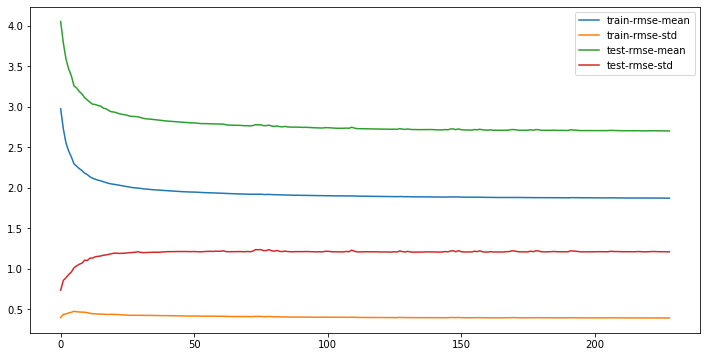

In [26]:
cv_model.plot.line(figsize=(12,6))

In [28]:
cv_model.shape[0]

229

In [29]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

parameters = {
    'subsample': 0.8,
    'min_child_weight': 7,
    'max_depth': 19,
    'learning_rate': 0.3,
    'gamma': 0.3,
    'colsample_bytree': 1,
    "tree_method":"gpu_hist",
    "n_estimators":229,
    "seed":seed}

reg = XGBRegressor(**parameters)

-cross_val_score(estimator=reg,
                 X=train[features],
                 y=train[target],
                 scoring="neg_root_mean_squared_error",
                 cv=folds).mean()

2.7017365296681723

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

parameters = {
    'subsample': 0.8,
    'min_child_weight': 7,
    'max_depth': 19,
    'learning_rate': 0.3,
    'gamma': 0.3,
    'colsample_bytree': 1,
    "tree_method":"hist",
    "n_jobs":32,
    "n_estimators":3000,
    "seed":seed,
    "verbosity":1}

reg = XGBRegressor(**parameters)

-cross_val_score(estimator=reg,
                 X=train[features],
                 y=train[target],
                 scoring="neg_root_mean_squared_error",
                 cv=folds).mean()

In [30]:
reg.set_params(**{"tree_method":"hist"})
model = reg.fit(X=train[features],
                y=train[target],)

In [32]:
from joblib import dump, load

model_name = "Model_XGBoost_Baseline_2020_12_15"

if model is not None:
    dump(model, Path(MODEL_PATH, model_name + ".joblib"))
else:
    model = load(Path(MODEL_PATH, model_name + ".joblib"))
    

## Predictions

In [39]:
pred = model.predict(test[features])
pred = np.clip(pred, 0, 20)

## Submission

In [43]:
submission = pd.DataFrame({"ID":range(pred.shape[0]),
                           "item_cnt_month":pred})

sub_file_name = "submission_" + model_name + ".csv"
sub_file_path = Path(MODEL_PATH, sub_file_name)

submission[["ID", "item_cnt_month"]].to_csv(sub_file_path, index=False)

In [44]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f $sub_file_path -m "Model_XGBoost_Baseline"

100%|███████████████████████████████████████| 3.29M/3.29M [00:03<00:00, 961kB/s]
Successfully submitted to Predict Future Sales